# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2024-2025, Q4
* Course homepage: https://brightspace.tudelft.nl/d2l/home/682445
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Niels Stienen (N.L.Stienen@student.tudelft.nl)
* (c) TU Delft, 2025

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE` and remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please **do not** delete it, instead run that cell as you would run all other cells. Finally, please **do not** add any extra cells to this notebook or change the existing cells unless you are explicitly asked to do so.

Please fill in your name(s) and other required details below:

In [39]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Mart Veldkamp"
STUDENT_1_STUDENT_NUMBER = "5885175"
STUDENT_1_NETID = "mmveldkamp"
STUDENT_1_EMAIL = "m.m.veldkamp@student.tudelft.nl"

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [40]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions (also after the course is finished), and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. Please note that it is **not** allowed to post any code relating to solution attempts. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA or if not possible otherwise, send an email to the instructor or TA.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for you that you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. 

* Please note that the above mentioned _read-only_ protection only works in Jupyter Notebook, and it does not work if you open this notebook in another editor (e.g., VSCode, PyCharm, etc.). Therefore, we recommend that you only use Jupyter Notebook for this course. If you use any other editor, you may accidentally delete cells, modify the tests, etc., which would cause you to lose points.

* If you edit a function that is imported in another notebook, you need to **restart the kernel** of the notebook where you are using the function. Otherwise, the changes will not be effective.

* **IMPORTANT**: Please make sure that your code executes without any errors before submitting the notebook. An easy way to ensure this is to use the validation script as described in the README.

# Task 3b - Familiarization with Multi-Input Single output GPs (5p)
**Authors:** Giovanni Franzese, Lorenzo Lyons (L.Lyons@tudelft.nl)

In [3]:
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm  # progress bar

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

## Task 3b.1 - Load the dataset with concrete data (0p)

In [4]:
data = pd.read_csv(Path("datasets") / "Concrete_Data.csv")
data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In this task, we will use the dataset with concrete data. The dataset is available in the file `concrete_data.csv`. The dataset contains 8 input variables and 1 output variable. The input variables are Cement, Blast Furnace Slag, Fly Ash, Water, Superplasticizer, Coarse Aggregate, Fine Aggregate, and Age. The output variable is the compressive strength of the concrete. 
We want to use a Gaussian Process to model the compressive strength of the concrete as a function of the other variables. Such a model can be useful in designing concrete mixtures or predicting the strength given the mixture properties. 
Let's divide the dataset into the training (80 %) and test (20 %) sets. We also initialize the 300 inducing points as randomly selected from the training set.

In [5]:
# Extract X and Y from the dataframe and convert to numpy arrays
data_numpy = data.to_numpy()
X = data_numpy[:, :-1]
Y = data_numpy[:, -1]

# Assuming X and Y are your features and labels, respectively
# Let's say you have 80% of the data for training and 20% for testing

# Set a random seed for reproducibility
np.random.seed(42)

# Get the number of samples in your dataset
num_samples = len(X)

# Define the percentage split
train_percentage = 0.8

# Calculate the number of samples for training
num_train_samples = int(train_percentage * num_samples)

# Generate random indices for the training set
train_indices = np.random.choice(num_samples, num_train_samples, replace=False)

# Use the remaining indices for the test set
test_indices = np.setdiff1d(np.arange(num_samples), train_indices)

# Split the data based on the generated indices
train_x, train_y = X[train_indices], Y[train_indices]
test_x, test_y = X[test_indices], Y[test_indices]

# create the training dataloader
train_x_torch = torch.from_numpy(train_x).double()
train_y_torch = torch.from_numpy(train_y).double()
train_dataset = TensorDataset(train_x_torch, train_y_torch)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

# pick inducing points randomly from the training data
num_inducing_points = 300
inducing_points_index = np.random.choice(
    num_train_samples, num_inducing_points, replace=False
)
inducing_points = torch.from_numpy(train_x[inducing_points_index, :]).double()

## Task 3b.2 - Construct a Sparse Gaussian Process with Multiple-Input Single Output (0.5p)
Choose the Zero mean or the constant mean according to the if/else statement of the class. Choose the kernel to be an RBF kernel with ARD (0.5p). In GPytorch, the ARD is implemented by setting the `ard_num_dims` parameter of the kernel to the number of input features.

In [30]:
class SVGPModel(ApproximateGP):
    def __init__(self, inducing_points, constant_mean=False):
        variational_distribution = CholeskyVariationalDistribution(
            inducing_points.size(0)
        )
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True,
        )
        super(SVGPModel, self).__init__(variational_strategy)
        if constant_mean:
            # self.mean_module =
            # YOUR CODE HERE
            self.mean_module = gpytorch.means.ConstantMean()
        else:  # Zero mean
            # self.mean_module =
            # YOUR CODE HERE
            self.mean_module = gpytorch.means.ZeroMean()

        # Use a RBF kernel with automatic relevance determination (ARD)
        # YOUR CODE HERE
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

## Task 3b.3 - Design a function for training the variational parameters (0.5p)
Correctly define the marginal log-likelihood, considering our model is an approximate SVGP.

In [31]:
def train_variational_parameters(likelihood, model, num_epochs: int = 2000):
    optimizer = torch.optim.Adam(
        [
            {"params": model.parameters()},
            {"params": likelihood.parameters()},
        ],
        lr=0.01,
    )

    # Our loss object. We're using the VariationalELBO
    # mll =
    # YOUR CODE HERE
    mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y_torch.size(0))

    model.train()
    likelihood.train()
    for i in tqdm(range(num_epochs)):
        # Within each iteration, we will go over each minibatch of data
        for x_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(x_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            optimizer.step()

## Task 3b.4 - Define a function for evaluating the model and computing metrics (1.5p)
When we predict the strength of a material, the absolute error is not the only metric we are interested in. We are going also to compute the accuracy of the model. We consider the prediction correct if the absolute error is less than two times the standard deviation, considering that the GP is a probabilistic model. Moreover, we are interested in quantifying the percentage of dangerous predictions. We consider a prediction dangerous if the model's lower confidence bound, i.e., the prediction minus two standard deviations, is higher than the actual value. This means that if the engineers use the lower confidence bound as a safety value for the strength of the material, they are still overestimating the strength, which may lead to undesired failures.


Compute the following metrics.
- Mean Absolute Error (MAE) on the train set
- Mean Absolute Error (MAE) on the test set
- Accuracy of the model on the train set (consider the prediction as correct if the absolute error is less than two times the standard deviation)
- Accuracy of the model on the test set (consider the prediction as correct if the absolute error is less than two times the standard deviation)
- Quantify the percentage of dangerous prediction, i.e., the prediction minus two standard deviations is higher than the actual value on the train set. 
- Quantify the percentage of dangerous prediction, i.e., the prediction minus two standard deviations is higher than the actual value, on the test set


In [32]:
def evaluate_model(likelihood, model):
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Evaluate the model on the test data
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x_torch = torch.from_numpy(test_x).double()
        test_y_torch = torch.from_numpy(test_y).double()

        train_pred = likelihood(model(train_x_torch))
        test_pred = likelihood(model(test_x_torch))

        # YOUR CODE HERE
        # Extract means and stds
        train_mean = train_pred.mean
        train_std = train_pred.stddev
        test_mean = test_pred.mean
        test_std = test_pred.stddev

        # 1. MAE
        mae_train = torch.mean(torch.abs(train_mean - train_y_torch)).item()
        mae_test = torch.mean(torch.abs(test_mean - test_y_torch)).item()

        # 2. Accuracy = abs(error) < 2 * std
        accuracy_train = (
            (torch.abs(train_mean - train_y_torch) < 2 * train_std).float().mean().item()
        )
        accuracy_test = (
            (torch.abs(test_mean - test_y_torch) < 2 * test_std).float().mean().item()
        )

        # 3. Dangerous prediction = lower bound > true value
        lower_train = train_mean - 2 * train_std
        lower_test = test_mean - 2 * test_std

        dangerous_prediction_train = (
            (lower_train > train_y_torch).float().mean().item()
        )
        dangerous_prediction_test = (
            (lower_test > test_y_torch).float().mean().item()
        )

        print(f"MAE on train set: {mae_train}")
        print(f"MAE on test set: {mae_test}")
        print(f"Accuracy on train set: {accuracy_train}")
        print(f"Accuracy on test set: {accuracy_test}")
        print(
            f"Dangerous percentage prediction on train set: {dangerous_prediction_train}"
        )
        print(
            f"Dangerous percentage prediction on test set {dangerous_prediction_test}"
        )

        return train_pred, test_pred

## Task 3b.5 - Train and evaluate the `SVGPModel` with a constant mean (1.5)
### Task 3b.5.1 - Initialize a constant mean model and the Gaussian Likelihood (0.5p)

In [33]:
# Set a random seed for reproducibility
np.random.seed(43)

# initialize the model
# model_constant_mean =
# likelihood_constant_mean =
# YOUR CODE HERE
model_constant_mean = SVGPModel(inducing_points)
likelihood_constant_mean = gpytorch.likelihoods.GaussianLikelihood()

model_constant_mean = model_constant_mean.double()
likelihood_constant_mean = likelihood_constant_mean.double()

# train the variational parameters
train_variational_parameters(likelihood_constant_mean, model_constant_mean)

  0%|          | 0/2000 [00:00<?, ?it/s]

### Task 3b.5.2 - Evaluate the model and print metrics (0.5p)

In [34]:
# Call the function to evaluate the model
# train_pred_constant_mean, test_pred_constant_mean =
# YOUR CODE HERE
train_pred_constant_mean, test_pred_constant_mean = evaluate_model(likelihood_constant_mean, model_constant_mean)

MAE on train set: 3.3885288529227657
MAE on test set: 6.268052803968135
Accuracy on train set: 0.9065533876419067
Accuracy on test set: 0.791262149810791
Dangerous percentage prediction on train set: 0.031553398817777634
Dangerous percentage prediction on test set 0.058252427726984024


### Task 3b.5.3 - Print the horizontal and the vertical length scales, and the constant mean value (0.5p)

In [35]:
print("Horizontal Lenghtscale of the kernel: ")
# YOUR CODE HERE
print(model_constant_mean.covar_module.base_kernel.lengthscale)

print("Vertical Lengthscale of the kernel: ")
# YOUR CODE HERE
print(model_constant_mean.covar_module.outputscale)

print("Constant mean value: ")
# YOUR CODE HERE
if isinstance(model_constant_mean.mean_module, gpytorch.means.ConstantMean):
    print(model_constant_mean.mean_module.constant.item())
else:
    print("ZeroMean (no constant)")

Horizontal Lenghtscale of the kernel: 
tensor([[58.6342]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Vertical Lengthscale of the kernel: 
tensor(38.0853, dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Constant mean value: 
ZeroMean (no constant)


### Task 3b.5.4 - Plot the predictions on the test set (0p)

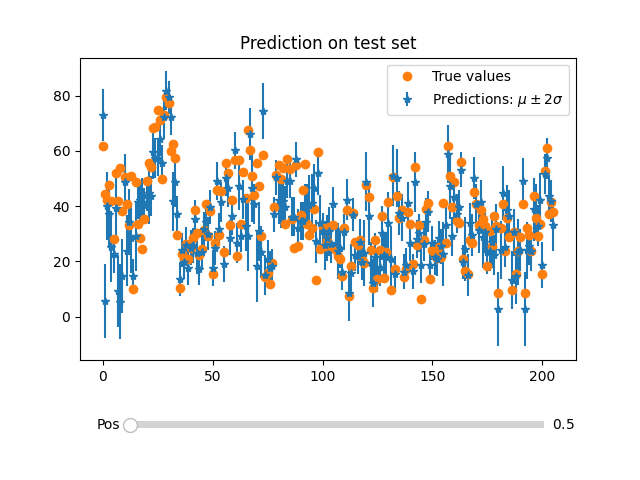

In [36]:
%matplotlib widget

# Setting fig and ax variables as subplots()
# function returns tuple(fig, ax)
fig, ax = plt.subplots()

# Adjust the bottom size according to the
# requirement of the user
plt.subplots_adjust(bottom=0.25)

index = np.arange(test_y.shape[0])
plt.errorbar(
    index,
    test_pred_constant_mean.mean.numpy(),
    yerr=2 * test_pred_constant_mean.stddev.numpy(),
    fmt="*",
    label="Predictions: $ \mu \pm 2 \sigma $",
)
plt.plot(index, test_y, "o", label="True values")

plt.title("Prediction on test set")
plt.legend()
# Choose the Slider color
slider_color = "White"

# Set the axis and slider position in the plot
axis_position = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor=slider_color)
slider_position = Slider(axis_position, "Pos", 0.1, 90.0)


# update() function to change the graph when the
# slider is in use
def update(val):
    pos = slider_position.val
    ax.axis([pos, pos + 20, 0, 100])
    fig.canvas.draw_idle()


# update function called using on_changed() function
slider_position.on_changed(update)
# Display the plot
plt.savefig(outputs_dir / "task_3b-5-4_predictions_on_test_set.pdf")
  
plt.show()

## Task 3b.6 - Train and evaluate the `SVGPModel` with zero mean (0.0p)

### Task 3b.6.0 - Instantiate and train Train the model (0.p)

In [37]:
# Set a random seed for reproducibility
np.random.seed(43)

# Define the model (with a zero mean) and the likelihood
# model_zero_mean =
# likelihood_zero_mean =
# YOUR CODE HERE
model_zero_mean = SVGPModel(inducing_points, constant_mean=False)
likelihood_zero_mean = gpytorch.likelihoods.GaussianLikelihood()

model_zero_mean = model_zero_mean.double()
likelihood_zero_mean = likelihood_zero_mean.double()

# Call the function to train the variational parameters
# YOUR CODE HERE
train_variational_parameters(likelihood_zero_mean, model_zero_mean)

# Call the function to evaluate the model
# train_pred_zero_mean, test_pred_zero_mean =
# YOUR CODE HERE
train_pred_zero_mean, test_pred_zero_mean = evaluate_model(likelihood_zero_mean, model_zero_mean)

  0%|          | 0/2000 [00:00<?, ?it/s]

MAE on train set: 3.3908550177414734
MAE on test set: 6.277106515265582
Accuracy on train set: 0.905339777469635
Accuracy on test set: 0.7766990065574646
Dangerous percentage prediction on train set: 0.031553398817777634
Dangerous percentage prediction on test set 0.06310679763555527


### Task 3b.6.1 - Print the horizontal and the vertical length scales (0.0p)

In [38]:
print("Horizontal Lenghtscale of the kernel: ")
# YOUR CODE HERE
print(model_zero_mean.covar_module.base_kernel.lengthscale)

print("Vertical Lengthscale of the kernel: ")
# YOUR CODE HERE
print(model_zero_mean.covar_module.outputscale)

Horizontal Lenghtscale of the kernel: 
tensor([[58.4892]], dtype=torch.float64, grad_fn=<SoftplusBackward0>)
Vertical Lengthscale of the kernel: 
tensor(38.1979, dtype=torch.float64, grad_fn=<SoftplusBackward0>)


## Task 3b.7 - Comparison of the two models (1p)
Comment on the difference between the predictions of the two sparse GP models (i.e., the one with constant and zero mean). Discuss the effect of the mean function, in particular, on the safety of the predictions.

#### SVGP Model with constant Mean:

- MAE on train set: 3.3885288529227657
- MAE on test set: 6.268052803968135
- Accuracy on train set: 0.9065533876419067
- Accuracy on test set: 0.791262149810791
- Dangerous percentage prediction on train set: 0.031553398817777634
- Dangerous percentage prediction on test set 0.058252427726984024

#### SVGP Model with Zero Mean:

- MAE on train set: 3.3908550177414734
- MAE on test set: 6.277106515265582
- Accuracy on train set: 0.905339777469635
- Accuracy on test set: 0.7766990065574646
- Dangerous percentage prediction on train set: 0.031553398817777634
- Dangerous percentage prediction on test set 0.06310679763555527

#### Conclusion

Some notes:

- The constant mean model performs slightly better across all metrics.
- The mean function affects safety: zero mean assumes outputs are centered around 0, which can lead to overconfident and unsafe predictions.
- The constant mean allows the GP to better fit the data baseline, resulting in fewer dangerous predictions on the test set.
- Both models are reasonably safe, but the zero mean model more often overestimates material strength, which can be risky.

A constant mean function improves both accuracy and safety. Mis-specifying the mean (as zero) leads to more unsafe predictions, highlighting its importance in safety-critical tasks like material strength prediction.

In [42]:
# YOUR CODE HERE
print("See Conclusion above")

See Conclusion above
